In [4]:
import torch
import sys
sys.path.insert(0, '../scripts/')
from models import model_dict
from dataset import Galaxy10DECals
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from e2cnn import nn as e2cnn_nn
import numpy as np
import torch.nn as nn
import warnings
# from escnn import nn as escnn_nn

warnings.filterwarnings('ignore')
device = ('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor()
    # transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
 ## have to write different one for densenet

In [5]:
def add_poisson_noise(image: np.array, snr: float):
    """
    Adds Poisson noise to an image with a specified intensity.

    Args:
        image (numpy.ndarray): The input image is a 256 x 256 x 3 numpy array.
        snr (float): Normalized snr value (between 0 and 1)

    Returns:
        numpy.ndarray: The noisy image as a 256 x 256 x 3 numpy array.
    """
    
    if (snr > 1) or (snr < 0):
        raise ValueError('Unphysical SNR value. Specify 0 < snr < 1')
    
    signal_level = np.mean(image.numpy())
    noise_level = signal_level / snr  - signal_level
    noise = np.random.poisson(lam=noise_level, size=image.shape)
    noisy_image = np.clip(image + noise, 0, 255).to(torch.uint8)
    
    return noisy_image

In [6]:
data = Galaxy10DECals('/Users/snehpandya/Projects/GCNNMorphology/data/Galaxy10_DECals.h5') ## removed transform
test_loader = DataLoader(data, batch_size=1, shuffle=True)

In [7]:
images, labels = next(iter(test_loader))
images = images.permute(0,3,1,2).to(torch.float32)

In [8]:
img = add_poisson_noise(images.squeeze().permute(1,2,0), 0.25)
img = img.unsqueeze(0).permute(0,3,2,1).to(torch.float32)

In [9]:
print(images.shape, images.dtype)
print(img.shape, img.dtype)

torch.Size([1, 3, 256, 256]) torch.float32
torch.Size([1, 3, 256, 256]) torch.float32


In [10]:
model_str = 'D8'
model = model_dict[model_str]()
model.load_state_dict(torch.load(f'/Users/snehpandya/Projects/GCNNMorphology/data/final_models/{model_str}.pt', map_location=device))

<All keys matched successfully>

In [11]:
model_str = 'WRN28_7_d8d4d1'
model_3 = model_dict[model_str]()
model_3.load_state_dict(torch.load(f'/Users/snehpandya/Projects/GCNNMorphology/data/final_models/{model_str}.pt', map_location=device))

| Wide-Resnet 28x7
start building 1
layer 1 built
start building 2
layer 2 built
start building 3
layer 3 built
MODEL TOPOLOGY:
	0 - 
	1 - conv1
	2 - conv1._basisexpansion
	3 - conv1._basisexpansion.block_expansion_('irrep_0,0', 'regular')
	4 - layer1
	5 - layer1.0
	6 - layer1.0.bn1
	7 - layer1.0.bn1.batch_norm_[16]
	8 - layer1.0.relu1
	9 - layer1.0.conv1
	10 - layer1.0.conv1._basisexpansion
	11 - layer1.0.conv1._basisexpansion.block_expansion_('regular', 'regular')
	12 - layer1.0.bn2
	13 - layer1.0.bn2.batch_norm_[16]
	14 - layer1.0.relu2
	15 - layer1.0.dropout
	16 - layer1.0.conv2
	17 - layer1.0.conv2._basisexpansion
	18 - layer1.0.shortcut
	19 - layer1.0.shortcut._basisexpansion
	20 - layer1.0.shortcut._basisexpansion.block_expansion_('regular', 'regular')
	21 - layer1.1
	22 - layer1.1.bn1
	23 - layer1.1.bn1.batch_norm_[16]
	24 - layer1.1.relu1
	25 - layer1.1.conv1
	26 - layer1.1.bn2
	27 - layer1.1.bn2.batch_norm_[16]
	28 - layer1.1.relu2
	29 - layer1.1.dropout
	30 - layer1.1.conv2


<All keys matched successfully>

In [22]:
model_str = 'ResNet18'
model_2 = model_dict[model_str]()
model_2.load_state_dict(torch.load(f'/Users/snehpandya/Projects/GCNNMorphology/data/final_models/{model_str}.pt', map_location=device))

Using cache found in /Users/snehpandya/.cache/torch/hub/pytorch_vision_v0.10.0


<All keys matched successfully>

In [16]:
def generate_rotations(image: torch.tensor):
    image_90 = torch.rot90(image, dims=(2,3))
    image_180 = torch.rot90(image_90, dims=(2,3))
    image_270 = torch.rot90(image_180, dims=(2,3))
    images = [image, image_90, image_180, image_270]
    return images

@torch.no_grad()
def visualize_feature_maps(model, image: torch.tensor, indices=None):
    model.eval()
    model_weights, conv_layers = [], []
    model_children = list(model.children())
    
    for i in range(len(model_children)):
        if type(model_children[i]) == nn.Conv2d:
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])

        # elif type(model_children[i]) == escnn_nn.R2Conv or type(model_children[i]) == e2cnn_nn.R2Conv:
        #     model_weights.append(model_children[i].weights)
        #     conv_layers.append(model_children[i].export())
           
        elif type(model_children[i]) == nn.Sequential:            
            for j in range(len(model_children[i])):
                for child in model_children[i][j].children():
                    if type(child) == nn.Conv2d:
                        model_weights.append(child.weight)
                        conv_layers.append(child)
                    # elif type(child) == escnn_nn.R2Conv or type(child) == e2cnn_nn.R2Conv:
                    #     model_weights.append(child.weights)
                    #     conv_layers.append(child.export())

                        
        elif type(model_children[i]) == e2cnn_nn.SequentialModule:  
            children_list = list(model_children[i].children()) 
            for j in range(len(children_list)):
                if type(children_list[j]) == e2cnn_nn.R2Conv: 
                # or type(children_list[j]) == escnn_nn.R2Conv:
                    model_weights.append(children_list[j].weights)
                    conv_layers.append(children_list[j].export())
                
    #model_weights, conv_layers = np.asarray(model_weights), np.asarray(conv_layers)
    
    assert len(conv_layers) == len(model_weights), "Number of conv layers and weights do not match"

    outputs = []
    names = []
    image_list = generate_rotations(image)
    image_list = [image.squeeze() for image in image_list]
    
    for images in image_list:
        for i, layer in enumerate(conv_layers):
            images = layer(images)
            if i == 0 or i == len(conv_layers) // 2 or i == len(conv_layers) - 1:
                outputs.append(images)
                names.append(str(layer))
    
    processed = []
    for feature_map in outputs:
        feature_map = feature_map.squeeze(0)
        gray_scale = torch.sum(feature_map,0)
        gray_scale = gray_scale / feature_map.shape[0]
        processed.append(gray_scale)
        
    images_to_plot = []

    num_rows = 4
    num_cols = int(len(processed) / num_rows)
    
    for i in range(num_rows):
        images_to_plot.append(image_list[i].permute(1,2,0).numpy().astype(np.uint8))
        images_to_plot.extend(processed[i*num_cols:(i+1)*num_cols])

    num_cols = num_cols + 1

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 5))
    # fig.suptitle('ResNet18 (Noise Level: 75%)', y=0.925, size=10)
    
    for i, ax in enumerate(axes.flatten()):
        if i < len(images):
            ax.imshow(images_to_plot[i])
            j += 1
            ax.axis('off')
 
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    # fig.savefig('../../plots/resnet18_75_fm.png', bbox_inches='tight', dpi=300)
    plt.show()


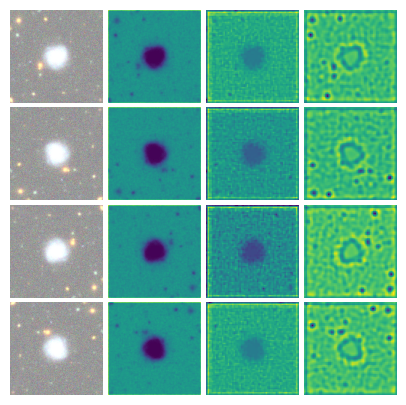

In [17]:
visualize_feature_maps(model, img)

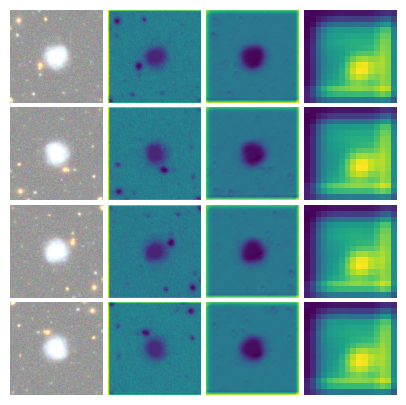

In [23]:
visualize_feature_maps(model_2, img)